In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
import re

from langdetect import detect
from scipy.stats import f_oneway
from collections import Counter

nltk.download("stopwords", quiet=True)

from nltk.stem.snowball import SpanishStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    f1_score,
    accuracy_score,
    recall_score,
)
from sklearn.linear_model import LogisticRegression
from gensim.models import Word2Vec

# 1. Exploración de datos


In [51]:
df_data = pd.read_excel(r"Datos_proyecto.xlsx")
df_data.head()

,textos,labels
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4
1,Para los niños más pequeños (bebés y niños peq...,4
2,"Además, la formación de especialistas en medic...",3
3,En los países de la OCDE se tiende a pasar de ...,4
4,Este grupo se centró en las personas que padec...,3


## 1.1 Calidad de datos

### 1.1.1 Completitud

Se observa que no hay valores nulos en el dataset, hay 2424 filas y 2 columnas, y para cada columna ha 2424 valores no nulos. La columna `textos` es de tipo objeto (string) y la columna `labels` es de tipo entero (int64).


In [52]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   textos  2424 non-null   object
 1   labels  2424 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 38.0+ KB


In [53]:
df_data.columns

Index(['textos', 'labels'], dtype='object')

In [54]:
df_data.count()

textos    2424
labels    2424
dtype: int64

In [55]:
# Valores nulos por columna
print("Datos Nulos")
print(df_data.isnull().sum())

Datos Nulos
textos    0
labels    0
dtype: int64


In [56]:
# Eliminar filas sin texto o etiqueta
df = df_data.dropna(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

In [57]:
# verificar si hay textos con strings vacíos
num_empty = (df["textos"].str.strip() == "").sum()
print("Número de textos vacíos:", num_empty)

Número de textos vacíos: 0


### 1.1.2 Unicidad

Se observa que no hay duplicados en el dataset.


In [58]:
duplicados = df.duplicated(subset=["textos"])
print(f"Duplicados encontrados: {duplicados.sum()}")

Duplicados encontrados: 0


In [59]:
# 6. Eliminar duplicados exactos (mismo texto y misma etiqueta)
df = df.drop_duplicates(subset=["textos", "labels"])
df.count()

textos    2424
labels    2424
dtype: int64

### 1.1.3 Validez

Revisar que todas las opiniones estén en el mismo idioma (español) y que las etiquetas sean del conjunto {1, 3, 4}.


In [60]:
# se demora alrededor de 20 segundos
def detect_language(text):
    try:
        return detect(text)
    except:
        return "unknown"


df["language"] = df["textos"].apply(detect_language)

print(len(df[df["language"] != "es"]))

0


In [61]:
# clases en el datset
df["labels"].unique()

array([4, 3, 1], dtype=int64)

Todos los textos están en español, no se encontraron textos en otros idiomas.


In [62]:
df = df.drop(columns=["language"])

### 1.1.4 Consistencia


In [63]:
df["word_count"] = df["textos"].apply(lambda x: len(str(x).split()))

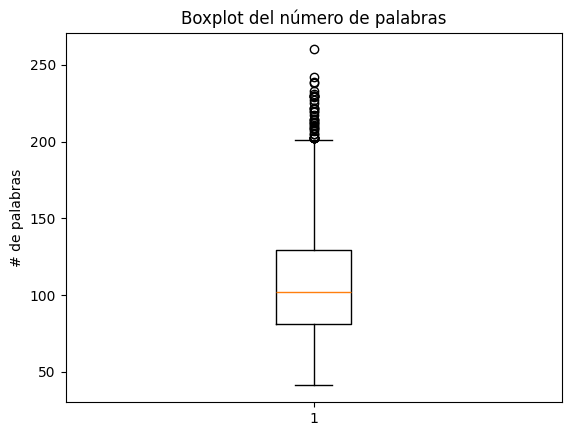

In [64]:
plt.boxplot(df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

Se observan outliers en textos que tienen una alta cantidad de palabras.


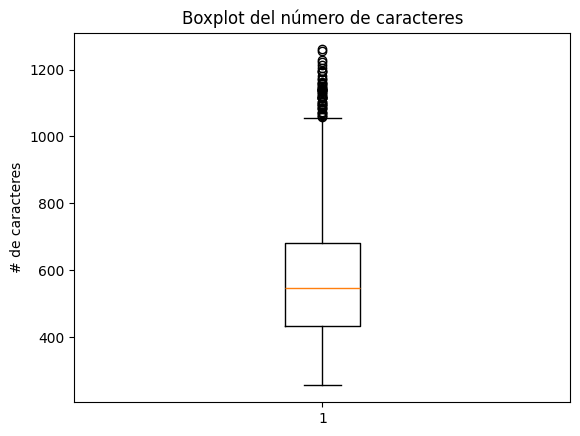

In [65]:
df["character_count"] = df["textos"].apply(
    lambda x: len(str(x.replace(" ", "").strip()))
)
plt.boxplot(df["character_count"])
plt.title("Boxplot del número de caracteres")
plt.ylabel("# de caracteres")
plt.show()
df = df.drop(columns=["character_count"])

# 2. Preparación de datos y continuación de la exploración


## 2.1 Tokenización y limpieza de texto

1. Definir función para limpiar y tokenizar el texto.
2. Aplicar la función a la columna "textos" y almacenar el resultado en una nueva columna.
3. Crear un dataframe de palabras tokenizadas para análisis posterior.


In [66]:
wpt = nltk.WordPunctTokenizer()
stop_words = set(nltk.corpus.stopwords.words("spanish"))

spanish_stemmer = SpanishStemmer()

def tokenize_text(text, stem=True):
    # Elimina caracteres especiales y espacios en blanco
    doc = re.sub(
            r"[^A-Za-zÁÉÍÓÚáéíóúÜüÑñ\s]",
            "",
            text,
            flags=re.U    # Unicode aware
        )
    doc = doc.lower()
    doc = doc.strip()
    # Tokenizar documento
    tokens = wpt.tokenize(doc)
    # Filtrar palabras
    filtered_tokens = [spanish_stemmer.stem(token) if stem else token for token in tokens if token not in stop_words]
    # Recrear documento de texto
    doc = " ".join(filtered_tokens)
    return doc, filtered_tokens


normalized_df = df.copy()
normalized_df[["tokenized_text", "tokens"]] = normalized_df["textos"].apply(
    lambda x: pd.Series(tokenize_text(x))
)

# recalcular word_count
normalized_df["word_count"] = normalized_df["textos"].apply(
    lambda x: len(str(x).split())
)

In [67]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaj educ consider sinon escolariz forma...,"[aprendizaj, educ, consider, sinon, escolariz,..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,niñ pequeñ bebes niñ pequeñ capacit especializ...,"[niñ, pequeñ, bebes, niñ, pequeñ, capacit, esp..."
2,"Además, la formación de especialistas en medic...",3,93,ademas formacion especial medicin general incl...,"[ademas, formacion, especial, medicin, general..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,pais ocde tiend pas curs obligatori optat abie...,"[pais, ocde, tiend, pas, curs, obligatori, opt..."
4,Este grupo se centró en las personas que padec...,3,94,grup centr person padec trastorn mental comorb...,"[grup, centr, person, padec, trastorn, mental,..."


## 2.2 Exploración de distribución de datos


### 2.2.1 Análisis de balance de clases


In [68]:
# 9. Distribución de etiquetas
print("Distribución de clases:")
dist_df = pd.DataFrame(
    {
        "cantidad": df["labels"].value_counts(),
        "porcentaje": round(df["labels"].value_counts() / len(df), 2),
    }
)
print(dist_df)

Distribución de clases:
        cantidad  porcentaje
labels                      
4           1025        0.42
3            894        0.37
1            505        0.21


In [69]:
colors = {1: "#1D8F97", 3: "#9bd137", 4: "#DA2C38"}

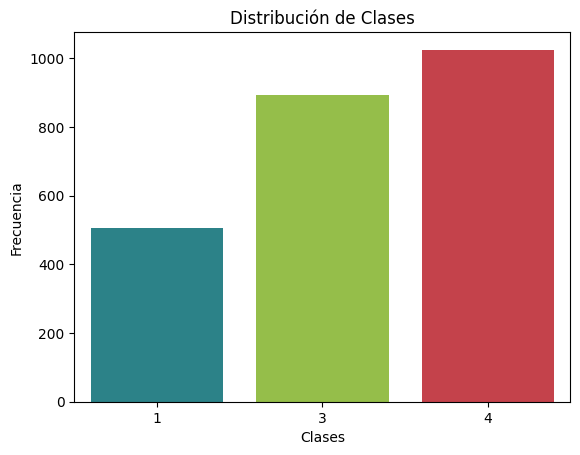

In [70]:
value_counts = df["labels"].value_counts()
x_values = value_counts.index
y_values = value_counts.values

sns.barplot(x=x_values, y=y_values, palette=colors, hue=x_values, legend=False)

plt.title("Distribución de Clases")
plt.xlabel("Clases")
plt.ylabel("Frecuencia")
plt.show()

Las clases 4 y 3 tienen una mayor representación en el dataset, mientras que las clases 1 tiene una representación menor.


### 2.2.2 Análisis de la distribución del número de palabras por clase


Se verifica que la diferencia entre las medias de la longitud de los textos de cada clase no sea significativa con una prueba _ANOVA_.


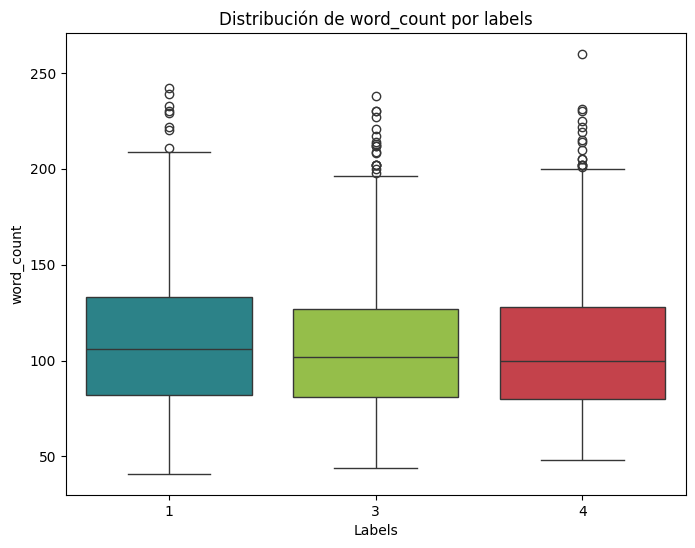

In [71]:
plt.figure(figsize=(8, 6))
sns.boxplot(
    x="labels", y="word_count", data=df, palette=colors, hue="labels", legend=False
)

plt.title("Distribución de word_count por labels")
plt.xlabel("Labels")
plt.ylabel("word_count")
plt.show()

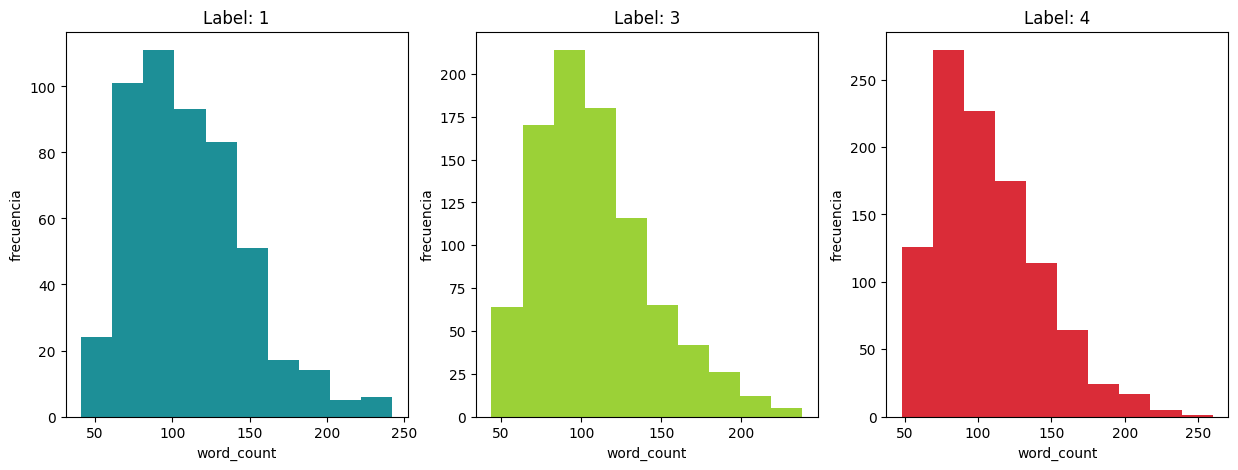

In [72]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

for i, label in enumerate(sorted(df["labels"].unique())):
    ax[i].hist(df[df["labels"] == label]["word_count"], color=colors[label])
    ax[i].set_xlabel("word_count")
    ax[i].set_ylabel("frecuencia")
    ax[i].set_title(f"Label: {label}")


plt.show()

Hipótesis Nula ($H_0$): No hay diferencia en la media de la variable numérica `word_count` para todos los grupos: $ \mu_1 = \mu_3 = \mu_4 $.

Hipótesis Alterna ($H_1$): Hay una diferencia en la media de la variable numérica `word_count` para al menos uno de los grupos: $ \mu_i \neq \mu_j $ para al menos un par $(i, j)$, donde $i, j \in \{1, 3, 4\}$ y $i \neq j$.


In [73]:
label1_group = normalized_df[normalized_df["labels"] == 1]["word_count"]
label3_group = normalized_df[normalized_df["labels"] == 3]["word_count"]
label4_group = normalized_df[normalized_df["labels"] == 4]["word_count"]

f_statistic, p_value = f_oneway(label1_group, label3_group, label4_group)

print("Resultados del Test ANOVA:")
print("=" * 30)
print(f"Estadístico F: {f_statistic:.4f}")
print(f"P-value: {p_value:.4f}")
print("=" * 30)

alpha = 0.05

print("Interpretación:")
if p_value < alpha:
    print(f"p-value ({p_value:.4f}) es menor que {alpha}.")
    print("Se rechaza la hipótesis nula (H0).")
    print(
        "Conclusión: Existe una diferencia estadísticamente significativa en la media de 'word_count' de al menos uno de los grupos."
    )
else:
    print(f"p-value ({p_value:.4f}) es mayor que {alpha}.")
    print("No se puede rechazar la hipótesis nula (H0).")
    print(
        "Conclusión: No hay evidencia suficiente para afirmar que las medias de 'word_count' son diferentes entre los grupos."
    )

Resultados del Test ANOVA:
Estadístico F: 1.8812
P-value: 0.1526
Interpretación:
p-value (0.1526) es mayor que 0.05.
No se puede rechazar la hipótesis nula (H0).
Conclusión: No hay evidencia suficiente para afirmar que las medias de 'word_count' son diferentes entre los grupos.


Dado el resultado de la prueba _ANOVA_ de una vía con $\alpha = 0.05$, no se puede rechazar la hipótesis nula, lo que indica que no hay evidencia suficiente para afirmar que existen diferencias significativas en la media de la variable `word_count` entre las diferentes clases.

De este modo, se tiene claridad en que la longitud de los textos no introduce un sesgo significativo en el análisis de las opiniones clasificadas en las diferentes clases.


### 2.2.3 Distribución del número de palabras en todo el dataset


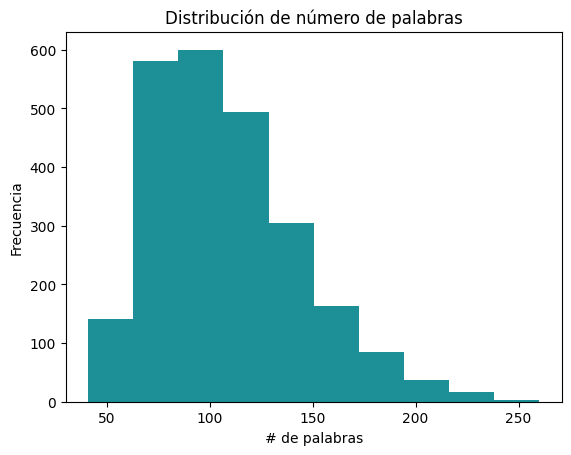

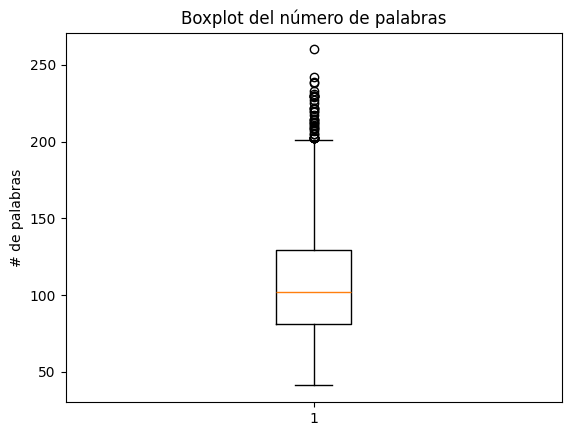

In [74]:
plt.hist(normalized_df["word_count"], color="#1D8F97")
plt.title("Distribución de número de palabras")
plt.xlabel("# de palabras")
plt.ylabel("Frecuencia")
plt.show()

plt.boxplot(normalized_df["word_count"])
plt.title("Boxplot del número de palabras")
plt.ylabel("# de palabras")
plt.show()

## 2.3 Exploración de las palabras más frecuentes y representativas por clase


Se quiere saber cuáles son las palabras más frecuentes en todo el dataset y por clase.


### 2.3.1 Palabras más frecuentes en todo el dataset


,word,frequency
0,educ,1452
1,pais,1147
2,salud,1130
3,estudi,1104
4,pobrez,1020
5,escuel,913
6,atencion,900
7,pued,897
8,mayor,752
9,mejor,740


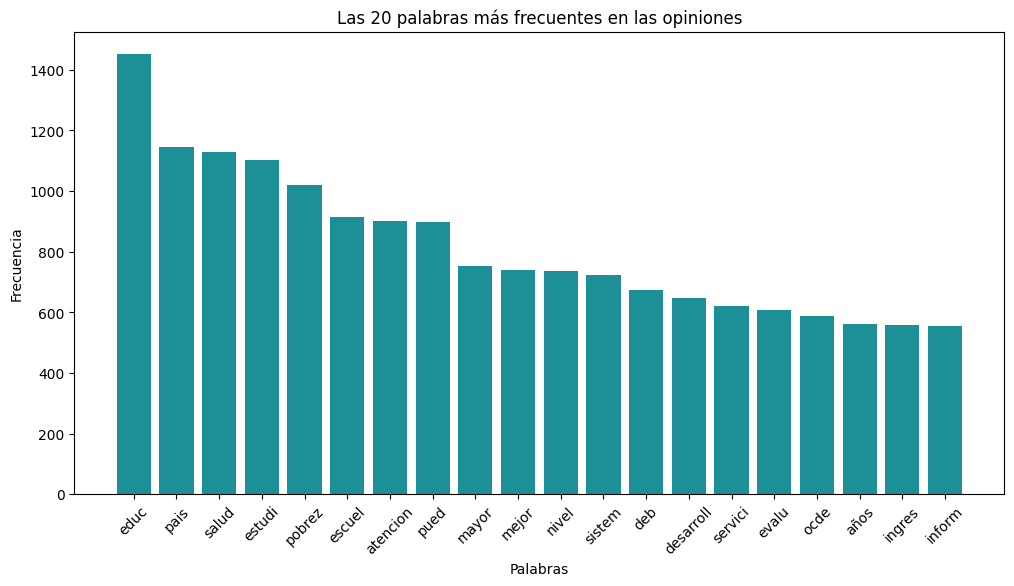

In [75]:
all_tokens = [token for tokens_list in normalized_df["tokens"] for token in tokens_list]

word_counts = Counter(all_tokens)

# Obtener las n palabras más comunes
n_words = 20
most_common_words = word_counts.most_common(n_words)

freq_df = pd.DataFrame(most_common_words, columns=["word", "frequency"])

display(freq_df)

# Graficar las palabras más frecuentes
plt.figure(figsize=(12, 6))
plt.bar(freq_df["word"], freq_df["frequency"], color="#1D8F97")
plt.xticks(rotation=45)
plt.title(f"Las {n_words} palabras más frecuentes en las opiniones")
plt.xlabel("Palabras")
plt.ylabel("Frecuencia")
plt.show()

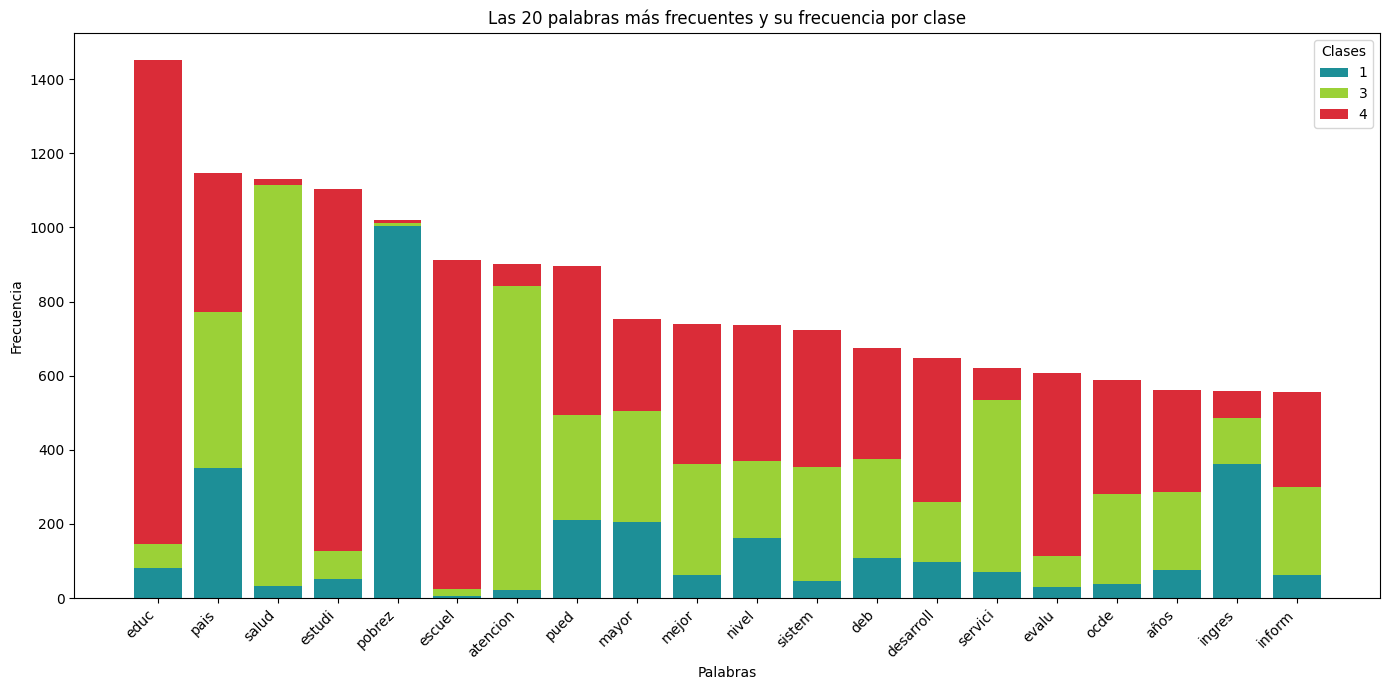

In [76]:
top_words = [word for word, count in most_common_words]

classes = sorted(normalized_df["labels"].unique())  # [1, 3, 4]
class_freq_data = {}

for label in classes:
    class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(class_tokens)

    # por cada una de las palabras del top, encontrar su frecuencia en la clase
    class_freq_data[label] = [class_word_counts.get(word, 0) for word in top_words]

plot_df = pd.DataFrame(class_freq_data, index=top_words)

fig, ax = plt.subplots(figsize=(14, 7))

bottom = np.zeros(len(top_words))  # iniciar la base de las barras en 0

for class_label, frequencies in plot_df.items():
    ax.bar(
        plot_df.index,
        frequencies,
        bottom=bottom,
        label=class_label,
        color=colors[class_label],
    )
    # Añadir la frecuencia a la base de la siguiente iteración
    bottom += frequencies.values

ax.set_title(f"Las {n_words} palabras más frecuentes y su frecuencia por clase")
ax.set_xlabel("Palabras")
ax.set_ylabel("Frecuencia")

ax.set_xticks(ax.get_xticks())  # This can help avoid a UserWarning
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

ax.legend(title="Clases")
plt.tight_layout()
plt.show()

### 2.3.2 Palabras más frecuentes por clase


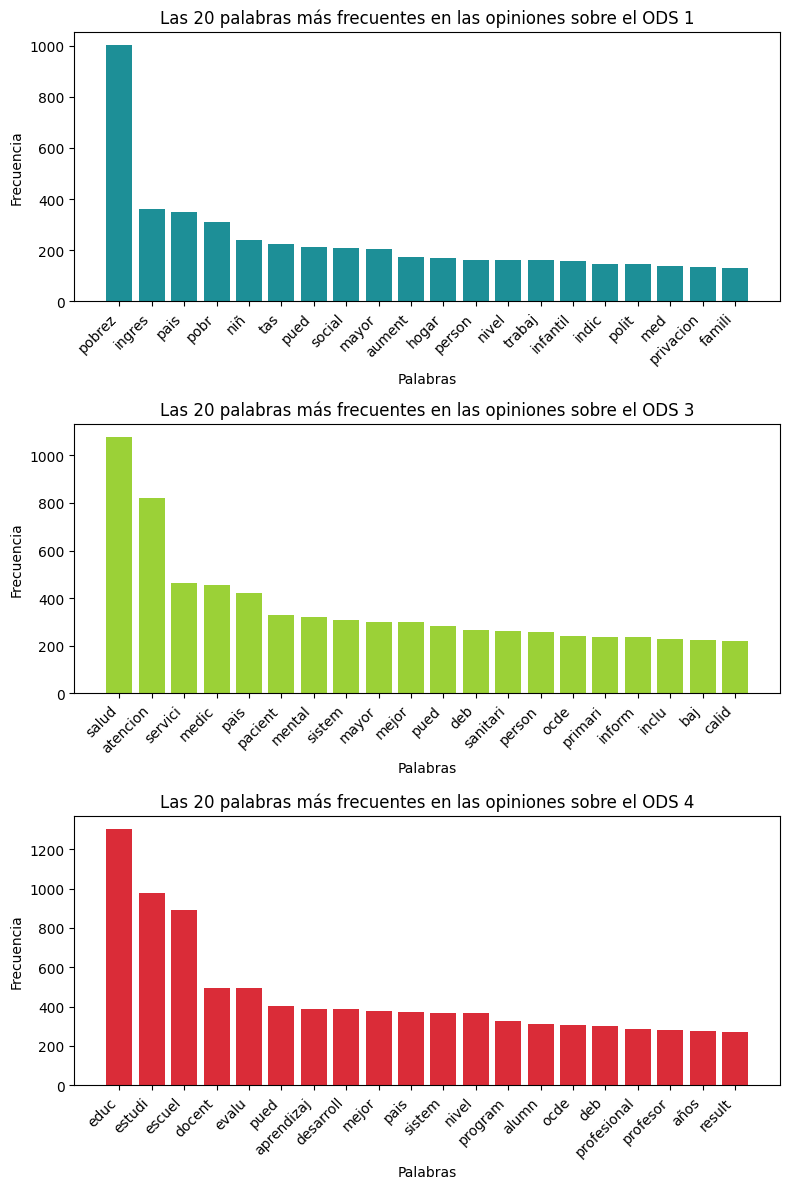

In [77]:
fig, ax = plt.subplots(3, 1, figsize=(8, 12))

for i, label in enumerate({1, 3, 4}):

    all_class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(all_class_tokens)

    # Obtener las n palabras más comunes
    top_class_words_counts = class_word_counts.most_common(n_words)

    label_freq_df = pd.DataFrame(top_class_words_counts, columns=["word", "frequency"])

    # Graficar las palabras más frecuentes para la clase
    ax[i].bar(label_freq_df["word"], label_freq_df["frequency"], color=colors[label])
    ax[i].set_xticks(ax[i].get_xticks())
    ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=45, ha="right")
    ax[i].set_title(
        f"Las {n_words} palabras más frecuentes en las opiniones sobre el ODS {label}"
    )
    ax[i].set_xlabel("Palabras")
    ax[i].set_ylabel("Frecuencia")

plt.tight_layout()
plt.show()

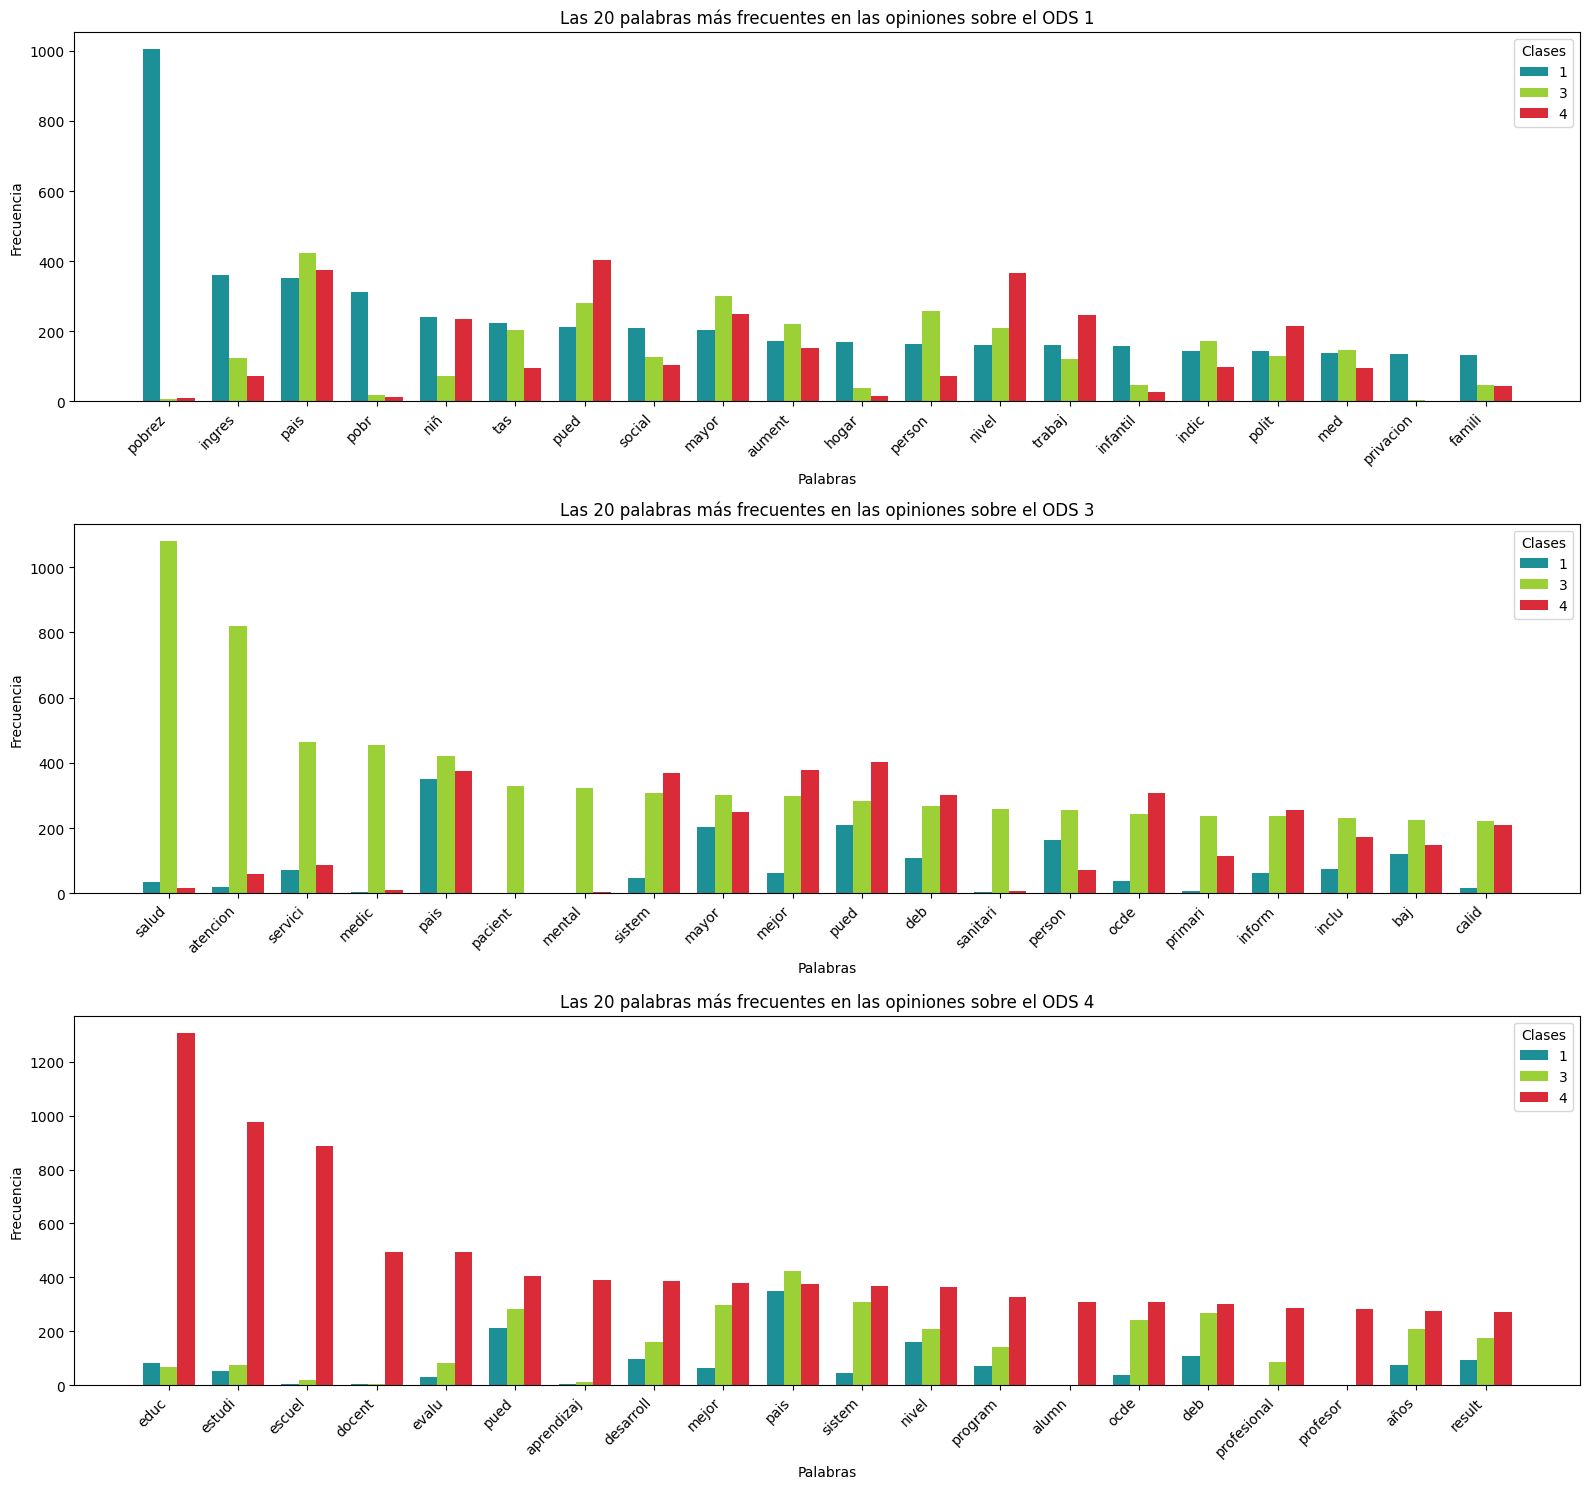

In [78]:
fig, ax = plt.subplots(3, 1, figsize=(16, 15))
bar_width = 0.25
n_classes = len(classes)
for i, label in enumerate({1, 3, 4}):

    all_class_tokens = [
        token
        for tokens_list in normalized_df[normalized_df["labels"] == label]["tokens"]
        for token in tokens_list
    ]

    class_word_counts = Counter(all_class_tokens)

    # Obtener las n palabras más comunes
    top_class_words_counts = class_word_counts.most_common(n_words)

    class_top_words = [word for word, count in top_class_words_counts]
    class_freq_data = {}

    for label2 in classes:
        # por cada una de las palabras del top, encontrar su frecuencia en las clases
        class_tokens = [
            token
            for tokens_list in normalized_df[normalized_df["labels"] == label2][
                "tokens"
            ]
            for token in tokens_list
        ]

        class_word_counts = Counter(class_tokens)

        class_freq_data[label2] = [
            class_word_counts.get(word, 0) for word in class_top_words
        ]

    label_freq_df = pd.DataFrame(class_freq_data, index=class_top_words)
    x_positions = np.arange(len(label_freq_df.index))
    # Graficar las palabras más frecuentes para la clase
    for j, class_name in enumerate(label_freq_df.columns):
        offset = bar_width * (j - (n_classes - 1) / 2.0)
        ax[i].bar(
            x_positions + offset,
            label_freq_df[class_name],
            width=bar_width,
            label=class_name,
            color=colors[class_name],
        )
    ax[i].set_xticks(x_positions)
    ax[i].set_xticklabels(label_freq_df.index, rotation=45, ha="right")
    ax[i].set_title(
        f"Las {n_words} palabras más frecuentes en las opiniones sobre el ODS {label}"
    )
    ax[i].set_xlabel("Palabras")
    ax[i].set_ylabel("Frecuencia")
    ax[i].legend(title="Clases")

plt.tight_layout()
plt.show()

In [79]:
normalized_df.head()

,textos,labels,word_count,tokenized_text,tokens
0,"""Aprendizaje"" y ""educación"" se consideran sinó...",4,48,aprendizaj educ consider sinon escolariz forma...,"[aprendizaj, educ, consider, sinon, escolariz,..."
1,Para los niños más pequeños (bebés y niños peq...,4,72,niñ pequeñ bebes niñ pequeñ capacit especializ...,"[niñ, pequeñ, bebes, niñ, pequeñ, capacit, esp..."
2,"Además, la formación de especialistas en medic...",3,93,ademas formacion especial medicin general incl...,"[ademas, formacion, especial, medicin, general..."
3,En los países de la OCDE se tiende a pasar de ...,4,109,pais ocde tiend pas curs obligatori optat abie...,"[pais, ocde, tiend, pas, curs, obligatori, opt..."
4,Este grupo se centró en las personas que padec...,3,94,grup centr person padec trastorn mental comorb...,"[grup, centr, person, padec, trastorn, mental,..."


Finalmente, antes de empezar con los métodos de extracción de features se realiza el split entre datos de entrenamiento y test con el fin de no producir data leakage y que el procesamiento sea el adecuado.


In [80]:
X = normalized_df["tokenized_text"]
y = normalized_df["labels"]
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Extracción de features

Para el proceso de extracción de features se utilizaron múltiples métodos con los cules se comparan los modelos que se realizan.


## N-M Gramas

Para empezar diferentes distribuciones de las palabras que pueda entrenar correctamente el modelo, se propone hacer un N-M Gama para ver como se ve la distribución de esta estrategia, y ver si es una posible estructura para predecir correctamente el texto.


En primer lugar se hace una prueba de 1-3 Gramas que clasifica tanto por unigramas, bigramas y trigramas que permite entender la dispersión general de su comportamiento. Este revisa si hay similitudes entre el BOW ya generado, o si agregar palabras concatenadas más largas permite mejorar la clasificación.

Asimismo, se hace el análisis sobre solo las palabras más utilizadas para ahorrar tiempo de computo, y para eliminar sesgos que pueden existir dentro de la clasificación


In [81]:
n_top_words = 50
top_words = [word for word, count in word_counts.most_common(n_top_words)]
bv = CountVectorizer(vocabulary=top_words, ngram_range=(1, 3))
bv_matrix = bv.fit_transform(normalized_df["tokenized_text"].tolist())
vocab = bv.get_feature_names_out()
print(vocab)
pd.DataFrame(bv_matrix[:5].toarray(), columns=vocab)

['educ' 'pais' 'salud' 'estudi' 'pobrez' 'escuel' 'atencion' 'pued'
 'mayor' 'mejor' 'nivel' 'sistem' 'deb' 'desarroll' 'servici' 'evalu'
 'ocde' 'años' 'ingres' 'inform' 'niñ' 'aument' 'program' 'result'
 'trabaj' 'tas' 'docent' 'person' 'baj' 'polit' 'inclu' 'medic' 'nacional'
 'part' 'calid' 'social' 'indic' 'public' 'aprendizaj' 'ejempl' 'diferent'
 'proporcion' 'dat' 'med' 'bas' 'profesional' 'embarg' 'centr' 'primari'
 'general']


,educ,pais,salud,estudi,pobrez,escuel,atencion,pued,mayor,mejor,...,diferent,proporcion,dat,med,bas,profesional,embarg,centr,primari,general
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,4,0,0,0,2,1,0,0,...,0,0,0,0,0,0,0,0,1,2
3,0,1,0,3,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,2,...,0,0,0,1,0,0,0,1,0,0


Como es tanta información no se alcanza a apreciar ninguna información relevante únicamente desde la matriz, por lo que se grafica para poder generar análisis más relevantes. De esta manera, también se distingue entre clases, ya que se quiere saber cuales son los 1-3 gramas más utilizados en cada una de las causas utilizadas para clasificar.


In [82]:
def comparar_ngrams_por_clase(ngram_range_param):
    n, m = ngram_range_param
    bv = CountVectorizer(ngram_range=ngram_range_param)
    labels = sorted(normalized_df["labels"].unique())
    top_n = 15
    fig, axes = plt.subplots(1, len(labels), figsize=(5 * len(labels), 4))
    fig.suptitle(f"Top {top_n} {n}-{m}-gramas", fontsize=16)

    for i, label in enumerate(labels):
        textos_clase = normalized_df[normalized_df["labels"] == label]["tokenized_text"]
        bv_matrix = bv.fit_transform(textos_clase)
        vocab = bv.get_feature_names_out()
        frecuencias = bv_matrix.sum(axis=0)
        frecuencias = np.array(frecuencias).flatten()
        top_indices = frecuencias.argsort()[::-1][:top_n]
        top_ngrams = [vocab[idx] for idx in top_indices]
        top_freqs = [frecuencias[idx] for idx in top_indices]
        sns.barplot(x=top_ngrams, y=top_freqs, color=colors[label], ax=axes[i])
        axes[i].set_xticks(range(len(top_ngrams)))
        axes[i].set_xticklabels(top_ngrams, rotation=45, ha="right")
        axes[i].set_title(f"Top {top_n} n-gramas - Clase {label}")
        axes[i].set_xlabel("n-grama")
        axes[i].set_ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

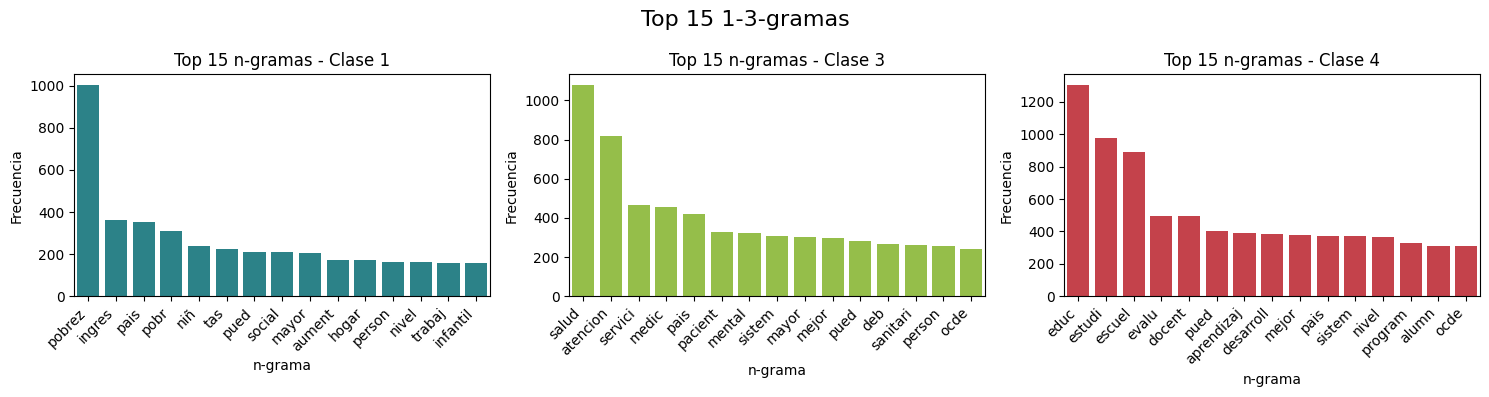

In [83]:
comparar_ngrams_por_clase((1, 3))

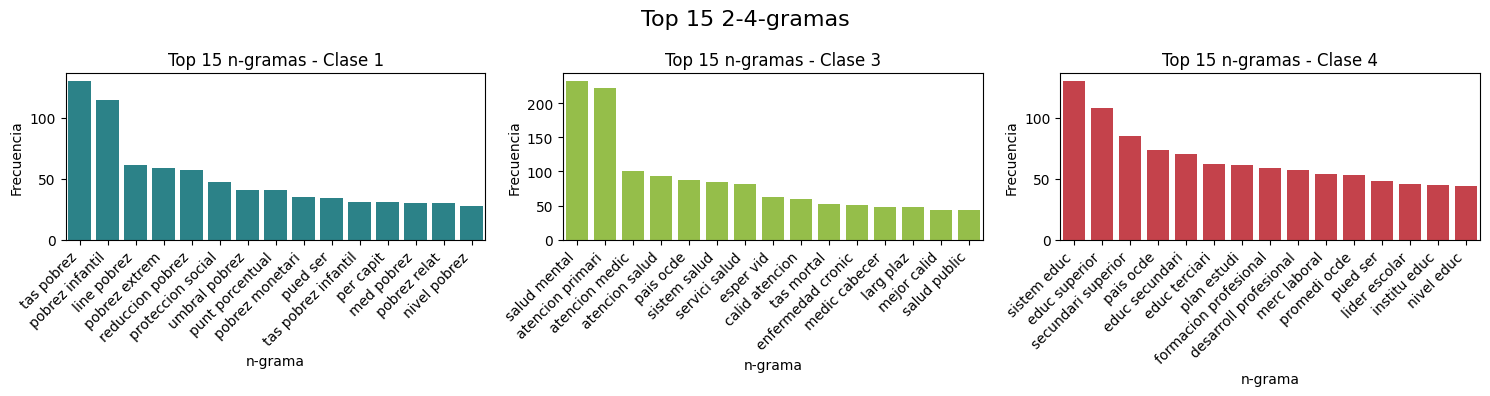

In [84]:
comparar_ngrams_por_clase((2, 4))

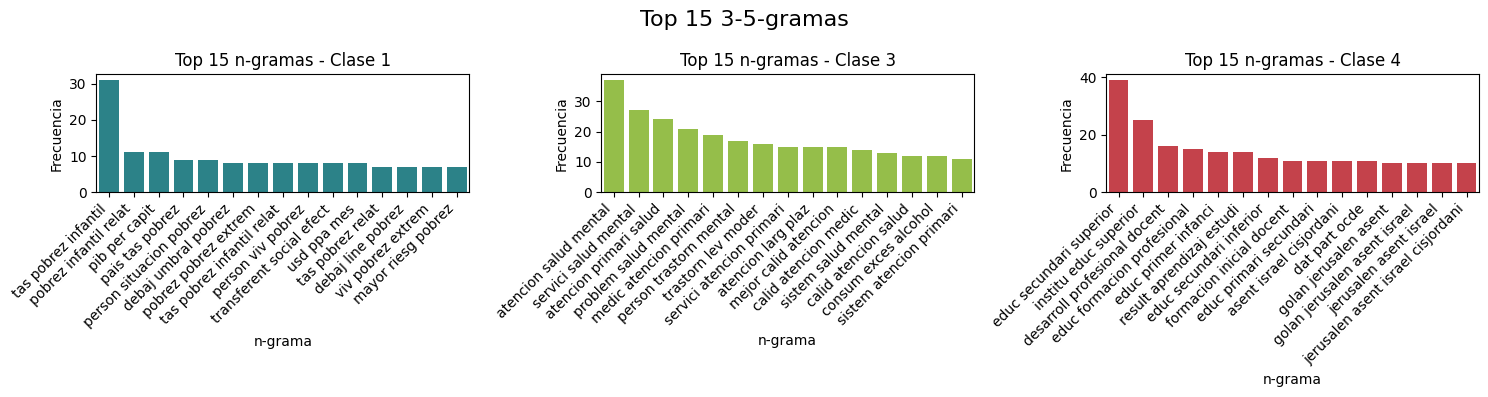

In [85]:
comparar_ngrams_por_clase((3, 5))

Estas tres versiones distintas de n-gramas (1-3-grama, 2-4 grama y 3-5 grama) evidencian que la estrategia que más información permite recolectar es un BOW ya que identifica el problema general, y son las palabras que más se repiten. Sin embargo, el uso de los otros n-m gramas ayudan a entender en que orden van estas palabras. Ver esta variación permite ver que un 1-3 n grama es el que más información relevante puede otorgar ya que se ve que cada una de estas (unigramas,bigramas y trigramas) presentan información relevante.


# TF-IDF para extracción de features

El uso de TF-IDF (Term Frequency–Inverse Document Frequency) para extracción de features consiste en evaluar la importancia de una palabra con respecto a una mayor cantidad de documentos.
Para esto, se considera la frecuencia de termino (TF) la cual mide la cantidad de apariciones de una palabra dentro del documento. La formula de esto es:

$ TF(t,d) = \frac{\# \, apariciones \, de \, t \,en\, d}{\#\, total\, de \,terminos\, en\, d}$

La otra parte que se utiliza dentro de este método es la frecuencia inversa de documento (IDF). Este parámetro tiene como fin reducir el peso de las palabras más comunes y asignarle un peso mayor a las palabras más raras. Esto debido, a que una palabra rara puede tener un significado más importante. Para esto, se utiliza la formula:

$IDF(t, D) = log \frac{\# \,total\, de\, documentos \,en \,D}{\# \,documentos\, con\, el\, termino\, t}$

Para implementar este método se utilizó `sklearn` con TfidfVectorizer. Para configurar este método se utilizaron las 1000 palabras más comunes dentro de los datos de entrenamiento, un máximo de 1000 iteraciones y se utiliza ngram_range el cual permite agregar limites para utilizar diferentes n-gramas.


In [86]:
def tf_idf_extraction(X_train_text, vectorizer):

    # Aplicar tf-idf sobre la columna con el texto tokenizado
    tfidf_matrix = vectorizer.fit_transform(X_train_text)

    tfidf_df = pd.DataFrame(
        tfidf_matrix.toarray(),
        columns=vectorizer.get_feature_names_out(),
        index=X_train_text.index,
    )
    final_df = tfidf_df
    return final_df, tfidf_matrix


def tf_idf_vectorizar(X_train_text):
    all_tokens = []
    for v in X_train_text:
        for w in v.split():
            all_tokens.append(w.strip())

    word_counts = Counter(all_tokens)

    n_words = 1000
    most_common_words = word_counts.most_common(n_words)
    top_words = [word for word, count in most_common_words]

    # Definir vectorizador TF-IDF sobre palabras más comunes
    vectorizer = TfidfVectorizer(vocabulary=top_words, ngram_range=(1, 3))
    return vectorizer


vectorizer = tf_idf_vectorizar(X_train_text)
final_df, tfidf_matrix = tf_idf_extraction(X_train_text, vectorizer)
display(final_df.head())

,educ,pais,salud,estudi,pobrez,escuel,atencion,pued,mejor,mayor,...,generaliz,intercambi,chec,remot,expansion,alla,lev,dificult,ausenci,presupuestari
2200,0.0,0.000000,0.117387,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.0,0.265505,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1844,0.0,0.070258,0.000000,0.000000,0.449513,0.000000,0.0,0.072976,0.15324,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1852,0.0,0.000000,0.000000,0.176841,0.000000,0.099242,0.0,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2344,0.0,0.000000,0.000000,0.119793,0.000000,0.000000,0.0,0.000000,0.00000,0.000000,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.00000,0.160329,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para visualizar el resultado del uso de extracción de features con TD-IDF se genera una gráfica de las palabras más comunes por clase a partir del valor promedio de TD-IDF.


C:\Users\david\AppData\Local\Temp\ipykernel_12336\1406913211.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")
C:\Users\david\AppData\Local\Temp\ipykernel_12336\1406913211.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")
C:\Users\david\AppData\Local\Temp\ipykernel_12336\1406913211.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")


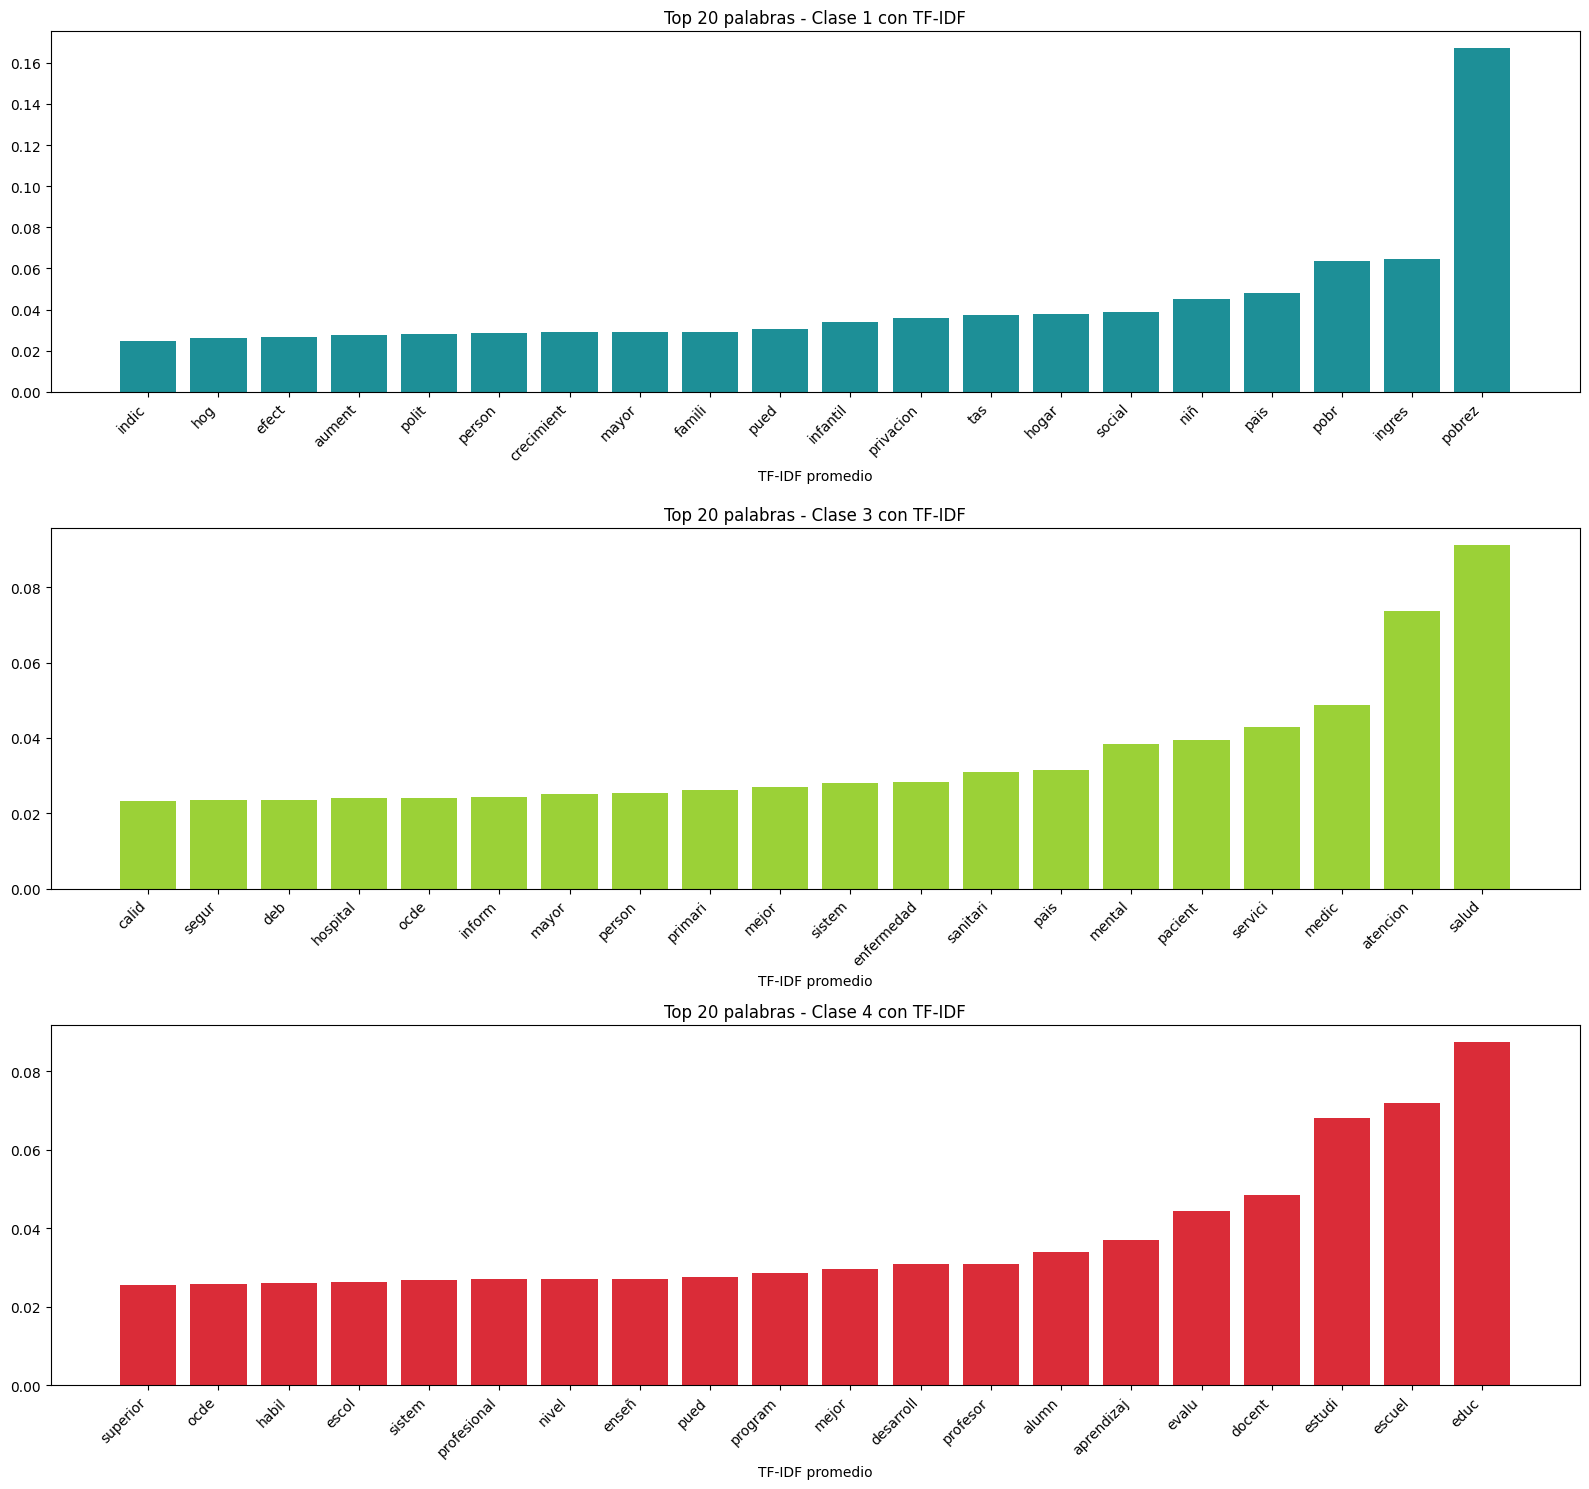

In [87]:
final_df = pd.concat([y_train, final_df], axis=1)
class_tfidf = final_df.groupby("labels").mean()

top_n = 20
fig, axes = plt.subplots(3, 1, figsize=(16, 15))

for i, label in enumerate(class_tfidf.index):
    top_features = class_tfidf.loc[label].sort_values(ascending=False)[:top_n]
    axes[i].bar(
        top_features.index[::-1], top_features.values[::-1], color=colors[label]
    )
    axes[i].set_title(f"Top {top_n} palabras - Clase {label} con TF-IDF")
    axes[i].set_xlabel("TF-IDF promedio")
    axes[i].set_xticklabels(top_features.index[::-1], rotation=45, ha="right")

plt.tight_layout()
plt.show()

## Document Similarity

Otra estrategia conocida para agrupar texto es el document similarity, que permite ver como se parecen las palabras entre si, muy útil para entrenar modelos no supervisados. Aunque este no es ese caso, si se desea estudiar esta estrategia para ver el comportamiento del texto, y ver cual va a ser su comportamiento general al momento de clasificarlo. Para esto se crea una matriz de similitud y luego se grafica.


In [88]:
similarity_matrix = cosine_similarity(tfidf_matrix)
similarity_df = pd.DataFrame(similarity_matrix)
similarity_df

,0,1,2,3,4,5,6,7,8,9,...,1929,1930,1931,1932,1933,1934,1935,1936,1937,1938
0,1.000000,0.035372,0.058409,0.000000,0.000000,0.052634,0.059365,0.079224,0.013001,0.031745,...,0.000000,0.006296,0.024978,0.183167,0.044763,0.048618,0.013102,0.000000,0.067442,0.023506
1,0.035372,1.000000,0.000000,0.031326,0.014873,0.000000,0.027137,0.024536,0.087975,0.026517,...,0.076226,0.025015,0.209717,0.057971,0.102198,0.029397,0.052283,0.008057,0.007193,0.031540
2,0.058409,0.000000,1.000000,0.091851,0.005030,0.043227,0.129102,0.095019,0.058814,0.019405,...,0.120546,0.029356,0.048350,0.038088,0.000000,0.030707,0.153331,0.040782,0.092014,0.023247
3,0.000000,0.031326,0.091851,1.000000,0.000000,0.065067,0.018097,0.011010,0.083913,0.052756,...,0.125725,0.000000,0.047769,0.027748,0.034834,0.120225,0.045980,0.140508,0.024365,0.032700
4,0.000000,0.014873,0.005030,0.000000,1.000000,0.000000,0.009370,0.000000,0.005142,0.000000,...,0.028243,0.016097,0.021081,0.007154,0.015461,0.044041,0.018770,0.005233,0.000000,0.023788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1934,0.048618,0.029397,0.030707,0.120225,0.044041,0.063383,0.202805,0.039035,0.027236,0.122234,...,0.065599,0.039767,0.089719,0.227139,0.126259,1.000000,0.107061,0.121295,0.016922,0.021643
1935,0.013102,0.052283,0.153331,0.045980,0.018770,0.138501,0.061618,0.075921,0.158111,0.021420,...,0.157283,0.055768,0.086344,0.118943,0.058901,0.107061,1.000000,0.196434,0.106142,0.027446
1936,0.000000,0.008057,0.040782,0.140508,0.005233,0.012432,0.052931,0.182326,0.075910,0.040510,...,0.328762,0.064230,0.081393,0.144873,0.091541,0.121295,0.196434,1.000000,0.011785,0.000000
1937,0.067442,0.007193,0.092014,0.024365,0.000000,0.014660,0.114771,0.030467,0.030028,0.022319,...,0.045078,0.034652,0.041273,0.037221,0.025277,0.016922,0.106142,0.011785,1.000000,0.019031


In [89]:
Z = linkage(similarity_matrix, "ward")
pd.DataFrame(
    Z,
    columns=[
        r"Document\Cluster 1",
        r"Document\Cluster 2",
        r"Distance",
        r"Cluster Size",
    ],
    dtype="object",
)

,Document\Cluster 1,Document\Cluster 2,Distance,Cluster Size
0,1643.0,1757.0,0.902394,2.0
1,786.0,1145.0,1.006314,2.0
2,832.0,1673.0,1.137314,2.0
3,13.0,619.0,1.174973,2.0
4,902.0,1730.0,1.268645,2.0
...,...,...,...,...
1933,3864.0,3865.0,15.500334,607.0
1934,3870.0,3872.0,18.495884,830.0
1935,3869.0,3871.0,26.046295,817.0
1936,3867.0,3874.0,36.187472,1109.0


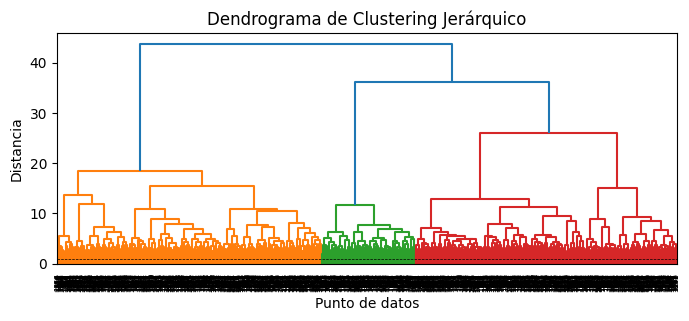

In [90]:
plt.figure(figsize=(8, 3))
plt.title("Dendrograma de Clustering Jerárquico")
plt.xlabel("Punto de datos")
plt.ylabel("Distancia")
dendrogram(Z)
plt.axhline(y=1.0, c="k", ls="--", lw=0.5)

Este resultado señala que hay conexiones entre el texto, donde entre mas bajo se encuentren en el árbol, más se parecen entre si. Las partes naranjas/verdes en la parte inferior muestran documentos muy similares entre sí mientras que las conexiones rojas en la parte superior indican grupos más grandes pero menos cohesionados. La altura mayor de las conexiones rojas sugiere mayor disimilitud entre estos grupos.

Esto nos dice que existen algunos grupos pequeños de documentos muy similares (clusters bajos) y hay una clara estructura jerárquica con 3 grupos principales. Este primer acercamiento resulta muy coherente con la clasificación de 3 grupos ODS que deseamos hacer. Asimismo, la altura de las conexiones sugiere que los documentos dentro de cada grupo principal son relativamente diferentes entre sí.

Esto nos dice que el dataset cuenta con diferencias lo suficientemente marcadas para generara una clasificación satisfactoria.


# Word2Vec

Este método de extracción de features permite obtener vectores de representación para las palabras teniendo en cuenta que 2 palabras que comparten contextos similares, deben compartir un significado similar. Este modelo se utiliza para encontrar las relaciones entre palabras lo que permite depués generar representaciones vecotriales de documentos a partir de estos vectores. El método de fonod utiliza una red neuronal y un clasificador softmax para generar los embeddings.
Para este caso se utiliza gensim para obtener los features.


In [91]:
from gensim.models import Word2Vec


def document_vector(doc, model):
    doc_new = []
    for word in doc:
        if word in model.wv.key_to_index:
            doc_new.append(word)
    if len(doc_new) == 0:
        return np.zeros(model.vector_size)
    else:
        return np.mean(model.wv[doc_new], axis=0)


def generate_features_w2v(model, corpus):
    vectors = []
    for text in corpus:
        doc_vec = document_vector(text, model)
        vectors.append(doc_vec)
    return np.array(vectors)


def word2vec_function(X_train_text):
    corpus = []
    for text in X_train_text:
        corpus.append(text.split())
    model = Word2Vec(
        sentences=corpus,
        vector_size=200,
        window=3,
        min_count=5,
        alpha=0.04,
        min_alpha=0.005,
    )
    return model, corpus


model_w2v, corpus_w2v = word2vec_function(X_train_text)
X_word2vec = generate_features_w2v(model_w2v, corpus_w2v)
display(X_word2vec)

array([[ 0.02312373, -0.08953534,  0.01253778, ..., -0.19007896,
        -0.05995976, -0.02610224],
       [-0.08144999,  0.09171584,  0.05509194, ..., -0.09072065,
        -0.05990897,  0.00043499],
       [-0.08091682, -0.02775426,  0.11132271, ..., -0.18705094,
        -0.03412388, -0.06222984],
       ...,
       [-0.00210094, -0.13498783,  0.04582638, ..., -0.22535123,
        -0.07358389,  0.03874112],
       [-0.0330392 , -0.07427616,  0.07754696, ..., -0.1794651 ,
        -0.02894019, -0.03671817],
       [-0.05019175,  0.01675714,  0.03529511, ..., -0.13446951,
        -0.03744939, -0.05912149]], dtype=float32)

# Modelos

# Naïve Bayes Multinomial

Explorado por: Maria Alejandra Angulo Mejia

El algoritmo Multinomial Naïve Bayes es un clasificador probabilístico que parte del Teorema de Bayes. Suponiendo que las características (en este caso, las palabras) son independientes entre sí dentro de un documento, el modelo estima la probabilidad de que un texto pertenezca a una clase (por ejemplo, un ODS) a partir de la frecuencia con la que aparecen las palabras en ese texto y en los documentos de entrenamiento de cada categoría.

El término multinomial se debe a que este algoritmo funciona muy bien con variables de conteo, como el número de veces que aparece cada palabra. De esta forma, si una palabra es más común en documentos de cierta clase, el modelo le da más peso a esa relación.

Entre sus ventajas están su sencillez, rapidez y buen rendimiento en tareas de clasificación de texto, incluso cuando se trabaja con grandes volúmenes de datos y vocabularios extensos. No obstante, suponer que todas las palabras son independientes es una limitación, ya que en el lenguaje suele haber relaciones entre términos.

Para evaluar su desempeño, se realizan pruebas de clasificación usando representaciones como BoW, n-gramas (1-3 y 1-5) y TF-IDF, con base en el análisis previo. La expectativa es que los 1-3 Gramas ayuden a mitigar, en parte, la suposición de independencia propia de Naïve Bayes.


## con N-M-Gramas


In [92]:
def n_grama(n_grama_param):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_train_ngram = vectorizer_ngram.fit_transform(X_train_text.fillna(""))
    X_test_ngram = vectorizer_ngram.transform(X_test_text.fillna(""))
    # Modelo
    nb_ngram = MultinomialNB()
    nb_ngram.fit(X_train_ngram, y_train)
    y_pred_ngram = nb_ngram.predict(X_test_ngram)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred_ngram, average="macro"))
    print("Accuracy:", accuracy_score(y_test, y_pred_ngram))
    print("Recall:", recall_score(y_test, y_pred_ngram, average="macro"))
    print(classification_report(y_test, y_pred_ngram))

In [93]:
print("BoW")
n_grama((1, 1))

BoW
N-grama (1, 1):
F1 score: 0.9545493210729262
Accuracy: 0.9587628865979382
Recall: 0.9588559814169569
              precision    recall  f1-score   support

           1       0.89      0.96      0.93       112
           3       0.98      0.95      0.96       168
           4       0.98      0.97      0.97       205

    accuracy                           0.96       485
   macro avg       0.95      0.96      0.95       485
weighted avg       0.96      0.96      0.96       485



In [94]:
n_grama((1, 3))
print("===============================")
n_grama((1, 5))

N-grama (1, 3):
F1 score: 0.9486227212607513
Accuracy: 0.954639175257732
Recall: 0.9429006968641115
              precision    recall  f1-score   support

           1       0.97      0.87      0.92       112
           3       0.94      0.98      0.96       168
           4       0.96      0.98      0.97       205

    accuracy                           0.95       485
   macro avg       0.96      0.94      0.95       485
weighted avg       0.96      0.95      0.95       485

N-grama (1, 5):
F1 score: 0.9407964746923557
Accuracy: 0.9484536082474226
Recall: 0.93397212543554
              precision    recall  f1-score   support

           1       0.97      0.84      0.90       112
           3       0.93      0.98      0.96       168
           4       0.95      0.98      0.97       205

    accuracy                           0.95       485
   macro avg       0.95      0.93      0.94       485
weighted avg       0.95      0.95      0.95       485



## Con TF-IDF


In [95]:
# Aplicar TF-IDF
vectorizer_tfidf = TfidfVectorizer(max_features=1000, min_df=5, max_df=0.90)
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train_text.fillna(""))
X_test_tfidf = vectorizer_tfidf.transform(X_test_text.fillna(""))

# Modelo
nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

print("TF-IDF con vocabulario predefinido:")
print("F1 score:", f1_score(y_test, y_pred_tfidf, average="macro"))
print("Accuracy:", accuracy_score(y_test, y_pred_tfidf))
print("Recall:", recall_score(y_test, y_pred_tfidf, average="macro"))
print(classification_report(y_test, y_pred_tfidf))

TF-IDF con vocabulario predefinido:
F1 score: 0.9608359563812735
Accuracy: 0.9628865979381444
Recall: 0.9604819976771196
              precision    recall  f1-score   support

           1       0.95      0.95      0.95       112
           3       0.98      0.96      0.97       168
           4       0.96      0.97      0.97       205

    accuracy                           0.96       485
   macro avg       0.96      0.96      0.96       485
weighted avg       0.96      0.96      0.96       485



Después de realizar las cuatro pruebas, se puede concluir cuál es la forma de vectorización más adecuada para Multinomial Naïve Bayes. Al analizar las métricas de f1-score, precisión y recall, se observa que tanto BoW como TF-IDF ofrecen un desempeño muy alto y prácticamente equivalente.

BoW alcanza un f1-score de 96.29%, una precisión de 96.70% y un recall de 96.41%, mientras que TF-IDF obtiene un f1-score de 96.37%, la misma precisión (96.70%) y un recall de 96.27%. Estas diferencias son mínimas y confirman que ambas representaciones mantienen una proporcionalidad similar en el uso de las palabras, lo que lleva al modelo a comportarse casi igual en ambos casos.

Sin embargo, se opta por utilizar TF-IDF como la estrategia a comparar de Multinomial Naïve Bayes con otros algoritmos , ya que presenta un f1-score ligeramente superior y un mejor equilibrio entre precisión y recall, lo cual es especialmente valioso para este proyecto.


# Logistic Regression

Explorado por: Laura Sofia Murcia

La regresión logística es un modelo de aprendizaje supervisado de clasificación. Este es un modelo lineal similar a la regresión lineal, pero que genera una salida categórica. Razón por la cual es aplicable a este problema.
Este modelo permite predecir la probabilidad de que un evento ocurra. Es decir, su método de clasificación es determinar que tan probable es cada evento de pertenecer a una clase.

La regresión logística multiclase se realiza usando una función softmax, la cual asigna probabilidades a cada clase. El modelo genera predicciones a partir de que clase tiene la mayor probabilidad. La función softmax sigue al formula:

$P(y=k) = \frac{e^{zk}}{\sum_j e^{zj}}$

En esta formula, $zk$ es el score de cada clase y se calcula sobre la suma de todos los scores de la clase para normalizar.

En particular, se utilizó el solver `saga` el cual según la documentación de la librería se adapta bien a modelos multiclases y se definen máximo 1000 iteraciones.


# Regresión Logística

## con TF-IDF

Se realiza un modelo con el uso de logistic regression y se calculan sus métricas. Se utilizan los datos preparados con TF-IDF para esto.


In [96]:
vectorizer = tf_idf_vectorizar(X_train_text)
tfidf_matrix_train = vectorizer.fit_transform(X_train_text)
tfidf_matrix_test = vectorizer.transform(X_test_text)

log_reg = LogisticRegression(solver="saga", max_iter=1000, random_state=42)
log_reg.fit(tfidf_matrix_train, y_train)

pred_labels = log_reg.predict(tfidf_matrix_test)
f1_macro = f1_score(y_test, pred_labels, average="macro")
accuracy = accuracy_score(y_test, pred_labels)
recall = recall_score(y_test, pred_labels, average="macro")

print("F1 score: ", f1_macro)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print(classification_report(y_test, pred_labels))

F1 score:  0.9707311647256543
Accuracy:  0.9731958762886598
Recall:  0.9693283004258614
              precision    recall  f1-score   support

           1       0.97      0.95      0.96       112
           3       0.96      0.98      0.97       168
           4       0.99      0.99      0.99       205

    accuracy                           0.97       485
   macro avg       0.97      0.97      0.97       485
weighted avg       0.97      0.97      0.97       485



# Logistic Regression with Word2Vec


In [97]:
model_w2v, corpus_w2v = word2vec_function(X_train_text)

X_train_w2v = generate_features_w2v(model_w2v, corpus_w2v)

corpus_test = []
for text in X_test_text:
    corpus_test.append(text.split())

X_test_w2v = generate_features_w2v(model_w2v, corpus_test)


# Modelo
clf = LogisticRegression(max_iter=1000, class_weight="balanced", random_state=42)
clf.fit(X_train_w2v, y_train)

# Evaluación
y_pred = clf.predict(X_test_w2v)
f1_macro = f1_score(y_test, y_pred, average="macro")
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred, average="macro")
print("F1 score: ", f1_macro)
print("Accuracy: ", accuracy)
print("Recall: ", recall)
print(classification_report(y_test, y_pred))

F1 score:  0.8999655855838791
Accuracy:  0.9092783505154639
Recall:  0.903382694541231
              precision    recall  f1-score   support

           1       0.82      0.88      0.85       112
           3       0.90      0.88      0.89       168
           4       0.97      0.95      0.96       205

    accuracy                           0.91       485
   macro avg       0.90      0.90      0.90       485
weighted avg       0.91      0.91      0.91       485



# con N-M-Gramas


In [98]:
def logistic_n_gram(n_grama_param, X_train, X_test, y_train, y_test):
    vectorizer_ngram = CountVectorizer(ngram_range=n_grama_param)
    X_train_ngram = vectorizer_ngram.fit_transform(X_train.fillna(""))
    X_test_ngram = vectorizer_ngram.transform(X_test.fillna(""))

    # Modelo
    log_n = LogisticRegression(max_iter=1000, random_state=42)
    log_n.fit(X_train_ngram, y_train)
    y_pred = log_n.predict(X_test_ngram)

    # Métricas
    print(f"N-grama {n_grama_param}:")
    print("F1 score:", f1_score(y_test, y_pred, average="macro"))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred, average="macro"))
    print(classification_report(y_test, y_pred))


logistic_n_gram((1, 3), X_train_text, X_test_text, y_train, y_test)
print("===============================")
logistic_n_gram((1, 5), X_train_text, X_test_text, y_train, y_test)

N-grama (1, 3):
F1 score: 0.9817747054475893
Accuracy: 0.9835051546391752
Recall: 0.9798828881145955
              precision    recall  f1-score   support

           1       0.99      0.96      0.97       112
           3       0.97      0.99      0.98       168
           4       0.99      0.99      0.99       205

    accuracy                           0.98       485
   macro avg       0.98      0.98      0.98       485
weighted avg       0.98      0.98      0.98       485

N-grama (1, 5):
F1 score: 0.9774732593131875
Accuracy: 0.979381443298969
Recall: 0.9752806813782424
              precision    recall  f1-score   support

           1       0.99      0.95      0.97       112
           3       0.96      0.99      0.98       168
           4       0.99      0.99      0.99       205

    accuracy                           0.98       485
   macro avg       0.98      0.98      0.98       485
weighted avg       0.98      0.98      0.98       485

